In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-and-train/train (1).csv
/kaggle/input/test-and-train/test.csv


# Data Preprocessing

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

# Load file paths
file_path_train = "/kaggle/input/test-and-train/train (1).csv"
file_path_test = "/kaggle/input/test-and-train/test.csv"

# Load training data
try:
    df_train = pd.read_csv(file_path_train)
except FileNotFoundError:
    raise FileNotFoundError(f"File not found at {file_path_train}")

# Load test data
try:
    df_test = pd.read_csv(file_path_test)
except FileNotFoundError:
    raise FileNotFoundError(f"File not found at {file_path_test}")

# Define features and targets
features = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N"]
targets = ["Y1", "Y2"]

# Verify columns exist in training data
required_columns = features + targets
missing_cols_train = [col for col in required_columns if col not in df_train.columns]
if missing_cols_train:
    raise ValueError(f"Missing columns in training dataset: {missing_cols_train}")

# Verify columns in test data (allow missing targets)
missing_cols_test = [col for col in features if col not in df_test.columns]
if missing_cols_test:
    raise ValueError(f"Missing columns in test dataset: {missing_cols_test}")

# Check data types
print("Training DataFrame dtypes:\n", df_train.dtypes)
print("Test DataFrame dtypes:\n", df_test.dtypes)
if not all(df_train[features].dtypes.apply(lambda x: np.issubdtype(x, np.number))):
    raise ValueError(f"Non-numeric data in training features: {df_train[features].dtypes}")
if not all(df_test[features].dtypes.apply(lambda x: np.issubdtype(x, np.number))):
    raise ValueError(f"Non-numeric data in test features: {df_test[features].dtypes}")
if all(col in df_train.columns for col in targets) and not all(df_train[targets].dtypes.apply(lambda x: np.issubdtype(x, np.number))):
    raise ValueError(f"Non-numeric data in training targets: {df_train[targets].dtypes}")

# Check for NaNs in original datasets
print("NaNs in original training DataFrame:", df_train.isna().sum().sum())
print("NaN counts per column in training DataFrame:\n", df_train.isna().sum())
print("NaNs in original test DataFrame:", df_test.isna().sum().sum())
print("NaN counts per column in test DataFrame:\n", df_test.isna().sum())

# Forward fill and backward fill NaNs in original datasets
df_train = df_train[features + targets].ffill().bfill()
df_test = df_test[features + (targets if all(col in df_test.columns for col in targets) else [])].ffill().bfill()
print("NaNs after ffill/bfill in training DataFrame:", df_train.isna().sum().sum())
print("NaNs after ffill/bfill in test DataFrame:", df_test.isna().sum().sum())

Training DataFrame dtypes:
 time      int64
A       float64
B       float64
C       float64
D       float64
E       float64
F       float64
G       float64
H       float64
I       float64
J       float64
K       float64
L       float64
M       float64
N       float64
Y1      float64
Y2      float64
dtype: object
Test DataFrame dtypes:
 id        int64
time      int64
A       float64
B       float64
C       float64
D       float64
E       float64
F       float64
G       float64
H       float64
I       float64
J       float64
K       float64
L       float64
M       float64
N       float64
dtype: object
NaNs in original training DataFrame: 0
NaN counts per column in training DataFrame:
 time    0
A       0
B       0
C       0
D       0
E       0
F       0
G       0
H       0
I       0
J       0
K       0
L       0
M       0
N       0
Y1      0
Y2      0
dtype: int64
NaNs in original test DataFrame: 0
NaN counts per column in test DataFrame:
 id      0
time    0
A       0
B       0
C      

# Feature Engineering

In [5]:
# 1. Lag and Shift Features
def create_lag_features(dframe, feature_vars, lags=[1, 7, 28]):
    df_lagged = dframe.copy()
    new_columns = {}
    for var in feature_vars:
        for lag in lags:
            new_columns[f'{var}_lag{lag}'] = df_lagged[var].shift(lag)
    new_columns_df = pd.DataFrame(new_columns, index=df_lagged.index)
    df_lagged = pd.concat([df_lagged, new_columns_df], axis=1)
    lag_columns = list(new_columns.keys())
    print("NaNs in lagged columns before ffill:", df_lagged[lag_columns].isna().sum().sum())
    df_lagged[lag_columns] = df_lagged[lag_columns].ffill().bfill()
    print("NaNs in lagged columns after ffill/bfill:", df_lagged[lag_columns].isna().sum().sum())
    return df_lagged

# 2. Rolling Window Statistics
def create_rolling_features(dframe, feature_vars, windows=[1, 7, 28], ema_span=7):
    df_metrics = dframe.copy()
    new_columns = {}
    for var in feature_vars:
        for window in windows:
            new_columns[f'{var}_mean_{window}d'] = df_metrics[var].rolling(window=window, min_periods=1).mean()
            new_columns[f'{var}_var_{window}d'] = df_metrics[var].rolling(window=window, min_periods=1).var().fillna(0)
            new_columns[f'{var}_std_{window}d'] = df_metrics[var].rolling(window=window, min_periods=1).std()
            new_columns[f'{var}_min_{window}d'] = df_metrics[var].rolling(window=window, min_periods=1).min()
            new_columns[f'{var}_max_{window}d'] = df_metrics[var].rolling(window=window, min_periods=1).max()
            new_columns[f'{var}_median_{window}d'] = df_metrics[var].rolling(window=window, min_periods=1).median()
        new_columns[f'{var}_ema_{ema_span}d'] = df_metrics[var].ewm(span=ema_span, adjust=False).mean()
    new_columns_df = pd.DataFrame(new_columns, index=df_metrics.index)
    df_metrics = pd.concat([df_metrics, new_columns_df], axis=1)
    rolling_columns = list(new_columns.keys())
    print("NaNs in rolling columns before ffill:", df_metrics[rolling_columns].isna().sum().sum())
    df_metrics[rolling_columns] = df_metrics[rolling_columns].ffill().bfill()
    print("NaNs in rolling columns after ffill/bfill:", df_metrics[rolling_columns].isna().sum().sum())
    return df_metrics

# 3. Seasonal and Periodic features 
def create_periodic_features(dframe, windows = [1, 7, 28]):
    df_metrics = dframe.copy()
    t = np.arange(len(dframe))
    new_columns = {}
    
    for window in windows:
        new_columns[f'sin_{window}d'] = np.sin(2 * np.pi * t / window)
        new_columns[f'cos_{window}d'] = np.cos(2 * np.pi * t / window)
    new_columns_df = pd.DataFrame(new_columns, index = dframe.index)
    df_metrics = pd.concat([df_metrics, new_columns_df], axis = 1)

    return df_metrics

# 4. Multivariate features 
def multivariate_features(dframe, feature_vars):

    if not isinstance(dframe, pd.DataFrame):
        raise ValueError("Input 'dframe' must be a pandas DataFrame")
    if not all(var in dframe.columns for var in feature_vars):
        raise ValueError("Not all 'feature_vars' are columns in 'dframe'")
    if dframe.empty:
        raise ValueError("Input 'dframe' is empty")
    
    df_metrics = dframe.copy()
    poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    poly_features = poly.fit_transform(dframe[feature_vars])
    poly_feature_names = poly.get_feature_names_out(feature_vars)
    
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_metrics.index)
    poly_df = poly_df.drop(columns=feature_vars, errors='ignore')
    
    df_metrics = pd.concat([df_metrics, poly_df], axis=1)
    
    if not df_metrics.index.equals(dframe.index):
        raise ValueError("Index misalignment after concatenation")
    
    return df_metrics

# Test for stationarity for SARIMA

In [6]:
# Test for stationarity 
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, name="Series"):
    series = series.ffill().bfill()
    result = adfuller(series)
    p_value = result[1]
    print(f"ADF Test for {name}: p-value = {p_value:.4f}")
    return p_value < 0.05  # Stationary if p-value < 0.05

p_y1 = test_stationarity(df_train["Y1"], name = "Y1")
p_y2 = test_stationarity(df_train["Y2"], name = "Y2")

print("p-value for Y1", p_y1)
print("p-value for Y2", p_y2)

ADF Test for Y1: p-value = 0.0000
ADF Test for Y2: p-value = 0.0000
p-value for Y1 True
p-value for Y2 True


# Visualization of the price series

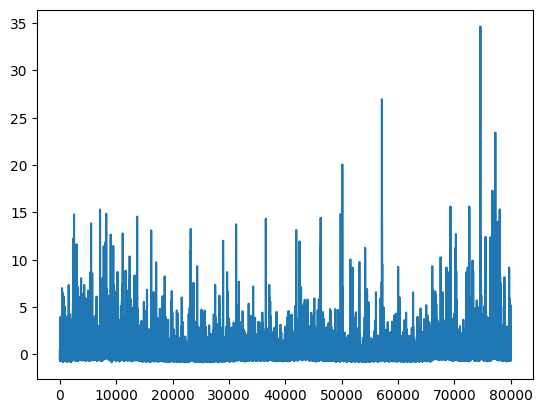

In [7]:
import matplotlib.pyplot as plt

t = np.arange(1, len(df_train) + 1,1)
# y1 = df_train["Y1"]
y2 = df_train["Y2"]

# plt.plot(t, y1)
plt.plot(t, y2)
plt.show()

In [ ]:
# === Process training data === 
df_train_lag = create_lag_features(df_train, features)
df_train_rolling = create_rolling_features(df_train_lag, features)

rolling_columns = [col for col in df_train_rolling.columns if col not in df_train_lag.columns]

df_train_combined = pd.concat([df_train_lag, df_train_rolling[rolling_columns]], axis=1)

# === Process test data === 
df_test_lag = create_lag_features(df_test, features)
df_test_rolling = create_rolling_features(df_test_lag, features)

rolling_columns = [col for col in df_test_rolling.columns if col not in df_test_lag.columns]
    
df_test_combined = pd.concat([df_test_lag, df_test_rolling[rolling_columns]], axis=1)

# === Process Seasonal and Periodic features ==== 
df_train_combined = create_periodic_features(df_train_combined)
df_test_combined = create_periodic_features(df_test_combined)

df_train_combined = multivariate_features(df_train_combined, features)
df_test_combined = multivariate_features(df_test_combined, features)

# Processing NaNs

In [4]:
# Check and handle NaNs in combined DataFrames
print("NaNs in combined training DataFrame before ffill:", df_train_combined.isna().sum().sum())
print("NaN counts per column in combined training DataFrame:\n", df_train_combined.isna().sum())
df_train_combined = df_train_combined.ffill().bfill()
print("NaNs in combined training DataFrame after ffill/bfill:", df_train_combined.isna().sum().sum())

print("NaNs in combined test DataFrame before ffill:", df_test_combined.isna().sum().sum())
print("NaN counts per column in combined test DataFrame:\n", df_test_combined.isna().sum())
df_test_combined = df_test_combined.ffill().bfill()
print("NaNs in combined test DataFrame after ffill/bfill:", df_test_combined.isna().sum().sum())

# Drop columns with all NaNs
all_nan_cols_train = df_train_combined.columns[df_train_combined.isna().all()].tolist()
if all_nan_cols_train:
    print("Dropping all-NaN columns in training data:", all_nan_cols_train)
    df_train_combined = df_train_combined.drop(columns=all_nan_cols_train)
    df_test_combined = df_test_combined.drop(columns=all_nan_cols_train, errors='ignore')

all_nan_cols_test = df_test_combined.columns[df_test_combined.isna().all()].tolist()
if all_nan_cols_test:
    print("Dropping all-NaN columns in test data:", all_nan_cols_test)
    df_test_combined = df_test_combined.drop(columns=all_nan_cols_test)

# Define features and targets for modeling
targets_new = ["Y1", "Y2"] if all(col in df_train_combined.columns for col in ["Y1", "Y2"]) else []
features_combined = [col for col in df_train_combined.columns if col not in targets_new]

# Ensure test data has the same features
missing_features_test = [col for col in features_combined if col not in df_test_combined.columns]
if missing_features_test:
    print("Warning: Test data missing features:", missing_features_test, ". Adding with NaNs.")
    for col in missing_features_test:
        df_test_combined[col] = np.nan
    df_test_combined[missing_features_test] = df_test_combined[missing_features_test].ffill().bfill()

# Drop rows with NaN targets in training data
if targets_new:
    nan_target_rows = df_train_combined[targets_new].isna().any(axis=1).sum()
    if nan_target_rows > 0:
        print("Dropping", nan_target_rows, "rows with NaN targets in training data")
        df_train_combined = df_train_combined.dropna(subset=targets_new)

# Verify and show results
print("Training Features:", features_combined)
print("Training Targets:", targets_new)
print("Combined Training DataFrame head:")
print(df_train_combined.head())
print("Final Training DataFrame shape:", df_train_combined.shape)
print("NaN values in combined Training DataFrame:", df_train_combined.isna().sum().sum())
print("Combined Test DataFrame head:")
print(df_test_combined.head())
print("Final Test DataFrame shape:", df_test_combined.shape)
print("NaN values in combined Test DataFrame:", df_test_combined.isna().sum().sum())
print("Done")

NaNs in combined training DataFrame before ffill: 1120000
NaN counts per column in combined training DataFrame:
 A        0
B        0
C        0
D        0
E        0
        ..
J M N    0
K L M    0
K L N    0
K M N    0
L M N    0
Length: 785, dtype: int64
NaNs in combined training DataFrame after ffill/bfill: 1120000
NaNs in combined test DataFrame before ffill: 223944
NaN counts per column in combined test DataFrame:
 A        0
B        0
C        0
D        0
E        0
        ..
J M N    0
K L M    0
K L N    0
K M N    0
L M N    0
Length: 783, dtype: int64
NaNs in combined test DataFrame after ffill/bfill: 223944
Dropping all-NaN columns in training data: ['A_std_1d', 'B_std_1d', 'C_std_1d', 'D_std_1d', 'E_std_1d', 'F_std_1d', 'G_std_1d', 'H_std_1d', 'I_std_1d', 'J_std_1d', 'K_std_1d', 'L_std_1d', 'M_std_1d', 'N_std_1d']
Training Features: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'A_lag1', 'A_lag7', 'A_lag28', 'B_lag1', 'B_lag7', 'B_lag28', 'C_l

# Calculating Feature importance

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare data
X_train = df_train_combined[selected_features]
y_train = df_train_combined[targets]
X_test = df_test_combined[selected_features]

# Time Series Split (confirm test_size; assuming 7 days if daily data)
tscv = TimeSeriesSplit(n_splits=5, test_size=7)  # Adjusted to 7 days

# Define single XGBoost model wrapped in MultiOutputRegressor
base_xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=80,
    max_depth=7,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=6,
    random_state=42
)
model = MultiOutputRegressor(base_xgb)

# Initialize arrays for OOF predictions and true values
n_targets = len(targets)
oof_xgb = np.zeros((len(y_train), n_targets))
oof_sarima = np.zeros((len(y_train), n_targets))
oof_y = np.zeros((len(y_train), n_targets))
r2_scores = {f'target_{i}': [] for i in range(n_targets)}

# Check for log transformation
is_log_transformed = any('log' in target for target in targets)

fold = 0
for train_idx, val_idx in tscv.split(X_train):
    fold += 1
    print(f"Fold {fold}")

    # Split data
    X_train_tmp, y_train_tmp = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_tmp, y_val_tmp = X_train.iloc[val_idx], y_train.iloc[val_idx]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_tmp)
    X_val_scaled = scaler.transform(X_val_tmp)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_tmp.columns, index=X_train_tmp.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val_tmp.columns, index=X_val_tmp.index)

    # Fit SARIMA and store OOF predictions
    for t_idx, target in enumerate(targets):
        sarima_model = SARIMAX(y_train_tmp[target], order=(1, 1, 1), seasonal_order=(1, 0, 1, 7))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred_val = sarima_fit.forecast(steps=len(val_idx))
        oof_sarima[val_idx, t_idx] = sarima_pred_val
        oof_y[val_idx, t_idx] = y_val_tmp[target]

    # Fit XGBoost and store OOF predictions
    model.fit(X_train_scaled, y_train_tmp)
    xgb_pred_val = model.predict(X_val_scaled)
    oof_xgb[val_idx, :] = xgb_pred_val

    # Meta-learner (Ridge) for each target using OOF predictions
    for t_idx, target in enumerate(targets):
        # Use OOF predictions from previous folds (if available) or current fold’s validation
        valid_idx = np.where(oof_xgb[:, t_idx] != 0)[0]
        if len(valid_idx) == 0:
            print(f"Warning: No OOF predictions for {target} in fold {fold}. Skipping meta-learner.")
            continue

        X_meta_train_tmp = np.column_stack([oof_xgb[valid_idx, t_idx], oof_sarima[valid_idx, t_idx]])
        y_meta_train_tmp = oof_y[valid_idx, t_idx]
        X_meta_val = np.column_stack([xgb_pred_val[:, t_idx], sarima_pred_val])

        # Fit meta-learner
        meta_model = Ridge(alpha=1.0)
        meta_model.fit(X_meta_train_tmp, y_meta_train_tmp)
        y_pred_val = meta_model.predict(X_meta_val)

        # Calculate R² (on original scale if log-transformed)
        if is_log_transformed:
            y_pred_val = np.expm1(y_pred_val)
            y_val_tmp_r2 = np.expm1(y_val_tmp[target])
        else:
            y_val_tmp_r2 = y_val_tmp[target]

        r2 = r2_score(y_val_tmp_r2, y_pred_val)
        r2_scores[f'target_{t_idx}'].append(r2)
        print(f"Fold R² for {target}: {r2:.4f}")

# Average CV R² per target
for t_idx, target in enumerate(targets):
    avg_r2 = np.mean(r2_scores[f'target_{t_idx}'])
    print(f"Average CV R² for {target}: {avg_r2:.4f}")

# === Final model training and test predictions ===

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Fit XGBoost on full training data
model.fit(X_train_scaled, y_train)
xgb_predictions_test = model.predict(X_test_scaled)

# Fit SARIMA on full training data for each target
sarima_predictions_test = np.zeros((len(X_test), n_targets))
for t_idx, target in enumerate(targets):
    sarima_model = SARIMAX(y_train[target], order=(1, 1, 1), seasonal_order=(1, 0, 1, 7))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_predictions_test[:, t_idx] = sarima_fit.forecast(steps=len(X_test))

# Meta-learner predictions
final_predictions = np.zeros((len(X_test), n_targets))
meta_models = []  # Store meta-learners for debugging

for t_idx, target in enumerate(targets):
    # Use all OOF predictions (non-zero)
    valid_idx = np.where(oof_xgb[:, t_idx] != 0)[0]
    if len(valid_idx) == 0:
        print(f"Warning: No valid OOF predictions for {target}. Using XGBoost predictions.")
        final_predictions[:, t_idx] = xgb_predictions_test[:, t_idx]  # Fallback to XGBoost
        continue

    X_meta_oof = np.column_stack([oof_xgb[valid_idx, t_idx], oof_sarima[valid_idx, t_idx]])
    y_meta_oof = oof_y[valid_idx, t_idx]

    # Fit meta-learner on OOF data
    meta_model = Ridge(alpha=1.0)
    meta_model.fit(X_meta_oof, y_meta_oof)
    meta_models.append(meta_model)

    # Combine test predictions
    X_meta_test = np.column_stack([xgb_predictions_test[:, t_idx], sarima_predictions_test[:, t_idx]])
    final_predictions[:, t_idx] = meta_model.predict(X_meta_test)

    # Inverse log transform if applied
    if is_log_transformed:
        final_predictions[:, t_idx] = np.expm1(final_predictions[:, t_idx])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [8]:
print("The Top 20 features are: ")
print(importance_df_1.head(20))
print("=" * 30)
print(importance_df_2.head(20))

print("The Top 20 features are: ")

The Top 20 features are: 
    Feature  Importance
413   A B K    0.215236
379     G J    0.089931
714   G H J    0.069297
6         G    0.057856
717   G H M    0.030974
469   A I K    0.020449
408   A B F    0.019533
451   A F K    0.016851
342     C G    0.015574
382     G M    0.015008
10        K    0.013069
576   C G H    0.012598
377     G H    0.011110
314     A B    0.008906
500   B D K    0.007581
323     A K    0.006241
434   A D K    0.006112
3         D    0.005115
429   A D F    0.005038
383     G N    0.004944
    Feature  Importance
413   A B K    0.215236
379     G J    0.089931
714   G H J    0.069297
6         G    0.057856
717   G H M    0.030974
469   A I K    0.020449
408   A B F    0.019533
451   A F K    0.016851
342     C G    0.015574
382     G M    0.015008
10        K    0.013069
576   C G H    0.012598
377     G H    0.011110
314     A B    0.008906
500   B D K    0.007581
323     A K    0.006241
434   A D K    0.006112
3         D    0.005115
429   A D F   